# Code for processing data NF0101train

## Import essential packages

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from ModelInference.SWInf import sliding_window_inference  



from model.TS_Net_change import FACT_Net
from IO.ReadNii import load_nii_inference
from IO.Read_tif import load_tiff, load_tif_video
from PreProcessing.Filters import median_filter_parallel
from PreProcessing.Thresh import thresh_max

import torch

# from monai.config import print_config
# print_config()

import numpy as np
import SimpleITK as sitk
from PIL import Image

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Number: {}".format(device))
print("GPU Number: {}".format(torch.cuda.get_device_name(0)))


GPU 编号: cuda:0
GPU 名称: NVIDIA GeForce RTX 3090


In [6]:
# Specifying the graphic card to use, especially when multiple GPUs exist in the same environment 
os.environ["CUDA_VISIBLE_DEVICE"] = "0"  
device = torch.device("cuda:0") 

## Load Image and Pre-process

### load image data

In [ ]:
data_path = "data/NeuroFinder-Registered/0100_train/NF0100train.tiff"  
input_img = load_tiff(data_path)  

In [ ]:
input_img.shape 

In [ ]:
# Performing Normalization to the input video data  
input_img = (input_img-input_img.min())/(input_img.max()-input_img.min())

image shape: (1825, 504, 504)


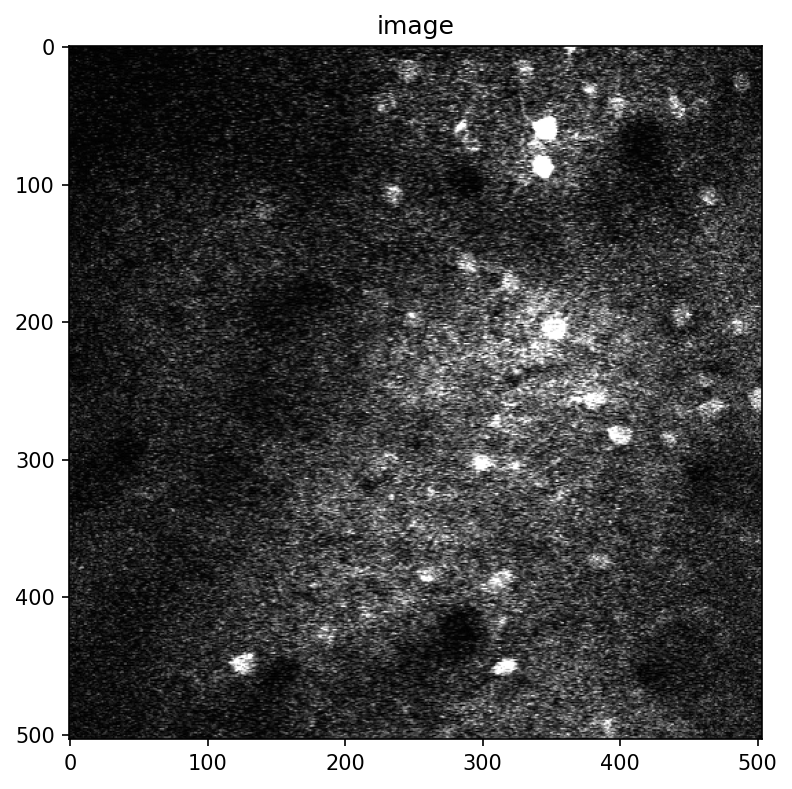

In [ ]:
# Optional showtime: display data preview if required
slice_num = 150
img_shape = input_img.shape
print(f"image shape: {img_shape}")
plt.figure("image", (18, 6),dpi=150)
plt.title("image")

plt.imshow(input_img[slice_num, :, :], cmap="gist_gray")
plt.show()

## Model Inference

### Building up model and loading parameters

In [ ]:
model_pth = "ModelParams/FACT_Modelparams.pt"
model = FACT_Net(
    img_size=(128,64,64),
    in_channels=1,
    out_channels=2,
    init_dim=3,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    use_checkpoint=True,
).to(device)

weight = torch.load(model_pth, map_location = 'cpu')
state_dict = weight["state_dict"]
model.load_state_dict(state_dict)

<All keys matched successfully>

#### Performing inference

In [ ]:
input_img_tensor = torch.from_numpy(input_img)
model.eval()
with torch.no_grad():
    test_inputs = torch.unsqueeze(input_img_tensor, 0)
    test_inputs = torch.unsqueeze(test_inputs, 1)
    test_outputs = sliding_window_inference(
        test_inputs, (128, 64, 64), sw_batch_size=32, predictor=model, overlap=[0.6,0.2,0.2], progress=True, mode="constant", 
        device=torch.device('cpu'), sw_device=device, 
    )

# device=torch.device('cpu')
torch.cuda.empty_cache()
print("Model Inference done")

In [ ]:
thresh = 0
diff = test_outputs[0,1,:,:,:] -  test_outputs[0,0,:,:,:]
infer_mask3d = np.zeros(diff.shape, dtype=np.int16)
infer_mask3d[torch.where(diff>thresh)] = 1

raw_vid = input_img[:,:,:] 
raw_vid = raw_vid.transpose(1,2,0) 
infer_mask3d = infer_mask3d.transpose(1,2,0)

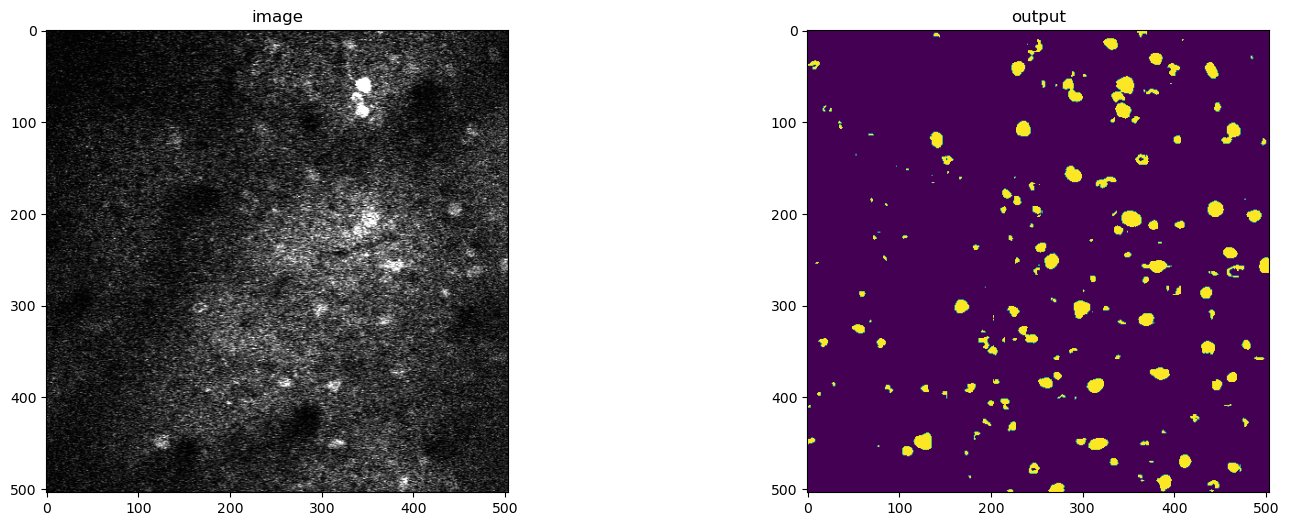

In [ ]:
# Optional: show model inference results
slice_num = 100
plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
# plt.imshow(test_inputs.cpu().numpy()[0, 0, slice_num, :, :], cmap="gray")
plt.imshow(raw_vid[:, :, slice_num], cmap="gray")
#     plt.subplot(1, 2, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
plt.subplot(1, 2, 2)
plt.title("output")
plt.imshow(
    infer_mask3d[:, :, slice_num]
)
plt.show()

## Postprocess using Slice Post-processing methods

### Import

In [33]:
import numpy as np
import scipy.sparse as sp
import time
import matplotlib.pyplot as plt

from PostSlice.IO.Readtif import load_tif_image 
from PostSlice.IO.ReadNii import load_nii_inference 
from PostSlice.UI.Drawmap import draw_mask_colormap 
from PostSlice.Evaluation.Jaccard import evaluation_jaccard 

from PostSlice.slice_connect import slice_connect 
from PostSlice.merger import merge_COM 
from PostSlice.refine_masks import refine_masks 
from PostSlice.further_merge import merge_IoU, merge_consume 
from PostSlice.filter_active import filter_active 

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.


### Transform

In [ ]:
# Re-orient the infer-masks for further post-processing

infer_mask3d = infer_mask3d.transpose(2,0,1)
infer_mask3d_shape = infer_mask3d.shape
mask_shape_2d = (infer_mask3d_shape[1], infer_mask3d_shape[2]) # 2d shape of the masks
(T, H, W) = infer_mask3d.shape
infer_mask3d = infer_mask3d.astype(np.uint8)
print(f'The shape of mask is {mask_shape_2d}')

### Start process

In [ ]:
Post_params = {} 
Post_params['max_area'] = 230

Post_params['min_area'] = 30
Post_params['thresh_COM'] = 5
Post_params['thresh_COM_refine'] = 6
Post_params['thresh_IoU'] = 0.7
Post_params['thresh_consume'] = (1+Post_params['thresh_IoU'])/2
Post_params['thresh_acti'] = 4
Post_params['thresh_refine'] = 0.2

Post_params['num_workers'] = 8

#### Process frame by frame 

In [ ]:
# Process each time slice 
time_st = time.time() 
masks, COMs, areas, timestamps = slice_connect(infer_3d=infer_mask3d, min_area=Post_params['min_area'], max_area=Post_params['max_area'], num_workers=Post_params['num_workers']) 
COMs = COMs.astype(np.float32)
print(f'time spent slice connect is {time.time()-time_st}s') 

print(f'masks: {masks.shape}, dtype:{masks.dtype}')   
print(f'COMs: {COMs.shape}, dtype:{COMs.dtype}')   
print(f'areas: {areas.shape}, dtype:{areas.dtype}')   
print(f'timestamps: {timestamps.shape}, dtype:{timestamps.dtype}')   

time_st = time.time() 
masks_merged_COM, timestamps_merged_COM = merge_COM(masks, COMs, timestamps, Post_params['thresh_COM']) 
print(f'time spent merging COM is {time.time()-time_st}s') 

time_st = time.time() 
masks_refined, timestamps_refined = refine_masks(masks=masks_merged_COM,
    thresh_dist=Post_params['thresh_COM_refine'], thresh_boarder=Post_params['thresh_refine'], 
    img_shape_2d=mask_shape_2d, valid_arr=None, timestamps=timestamps_merged_COM)
print(f'time spent refinning the mask is {time.time()-time_st}s') 
print(f'number of masks after refinning is {masks_refined.shape[0]}') 

# First merge masks according to IoU metric between masks
time_st = time.time() 
masks_merged_IoU, timestamps_merged_IoU = merge_IoU(masks=masks_refined, 
        timestamps=timestamps_refined, thresh_refine=Post_params['thresh_refine'],
        thresh_IoU=Post_params['thresh_IoU'])
print(f'time spent IoU merging the mask is {time.time()-time_st}s')
print(f'number of masks after IoU merging is {masks_merged_IoU.shape[0]}')

# Second merge masks according to the consume ratios
time_st = time.time() 
masks_merged_consume, timestamps_merged_consume = merge_consume(masks=masks_merged_IoU, 
        timestamps=timestamps_merged_IoU, thresh_refine=Post_params['thresh_refine'], 
        thresh_consume=Post_params['thresh_consume'], max_area=Post_params['max_area']) 
print(f'time spent consume merging the mask is {time.time()-time_st}s') 
print(f'number of masks after consume merging is {masks_merged_consume.shape[0]}') 

time_st = time.time()  
masks_final, timestamps_final = filter_active(masks_merged_consume, timestamps_merged_consume,  
              Post_params['thresh_acti'], Post_params['thresh_refine'])  
print(f'time spent filtering the masks is {time.time()-time_st}s')  
print(f'number of masks after filtering is {masks_final.shape[0]}')  



### Import GT and calculate evaluation metrics

In [ ]:
from IO.ReadmatMask import read_mat_mask 
# from IO.Drawmap import draw_mask_colormap 

In [ ]:
masks_GT = read_mat_mask('data/NeuroFinder-Registered/0101_train/NF0101train__GTmasks.mat', mask_shape_2d=mask_shape_2d) 

In [ ]:
# running evaluation and output the evaluation results 
from PostSlice.Evaluation.Jaccard_sparse import evaluation_jaccard  
[match_gt_list, precision, recall, F1] = evaluation_jaccard(masks_final, masks_GT, 0.5)  

print(f'F1: {F1}')  
print(f'Precision: {precision}')  
print(f'Recall: {recall}')  
  
print('Finished')  

F1: 0.75
Precision: 0.8169014084507042
Recall: 0.6932270916334662
Finished
